In [1]:
import numpy  as np
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import interpolate
import seaborn as sns
from scipy.interpolate import interp1d

In [23]:
def sim_EV(df_inp_veh , df_inp_cycle , MotorEffData ) :
    
    df_op_scalars = pd.DataFrame([])
    df_op = pd.DataFrame([])
    
    mass          = float(df_inp_veh['mass'])
    a             = float(df_inp_veh['a'])
    b             = float(df_inp_veh['b'])
    c             = float(df_inp_veh['c'])
    wheel_radius  = float(df_inp_veh['wheel_radius'])
    GR            = float(df_inp_veh['GR'])
    eff_GB        = float(df_inp_veh['eff_GB'])
    eff_Mot       = float(df_inp_veh['eff_Mot'])
    Batt_WtDen    = float(df_inp_veh['Batt_WtDen'])
    Batt_volt_nom = float(df_inp_veh['Batt_volt_nom'])
    range_des     = float(df_inp_veh['range_des'])
    Aux_pwr       = float(df_inp_veh['Aux_pwr'])   
    regen_fact    = float(df_inp_veh['regen_fact'])
    brk_dstr      = float(df_inp_veh['brk_dstr'])
    grad          = float(df_inp_veh['grad'])   
    
    time_column_tag = 'Time'
    speed_column_tag = 'Speed'
    time = df_inp_cycle[time_column_tag].to_numpy()
    speed = df_inp_cycle[speed_column_tag].to_numpy()

    veh_dist = np.append( 0 , integrate.cumtrapz(speed*5/18 , time ))
    acc = np.append( 0, np.diff(speed*5/18) / np.diff(time) )
    
    Wheel_Tq_acc = ((mass*acc)) * wheel_radius
    Wheel_Tq_A = (np.full(len(time) , a)) * wheel_radius
    Wheel_Tq_A[speed==0] = 0 
    Wheel_Tq_B = (b*speed) * wheel_radius
    Wheel_Tq_C = (c*speed * speed) * wheel_radius
    Wheel_Tq_grad = (mass*9.81*np.sin(np.arctan(grad))) * wheel_radius
    
    Wheel_Tq = np.zeros(len(time))
    Wheel_Tq = ((mass*acc) + (a) + (b*speed) + (c*speed * speed) + (mass*9.81*np.sin(np.arctan(grad))) ) * wheel_radius
    Wheel_Tq[speed==0] = 0
    Wheel_RPM = speed * 5 / 18 / wheel_radius * 60 / 2 / 3.14 
    Wheel_Pwr = 2 * 3.14 * Wheel_RPM * Wheel_Tq / 60000

    Emac_Tq = np.zeros(len(time))
    Emac_Tq[Wheel_Tq>=0] = Wheel_Tq[Wheel_Tq>=0] / GR / eff_GB
    Emac_Tq[Wheel_Tq<0]  = Wheel_Tq[Wheel_Tq<0]  / GR / eff_GB * brk_dstr * regen_fact
    Emac_RPM = Wheel_RPM * GR
    Emac_Pwr = 2 * 3.14 * Emac_RPM * Emac_Tq / 60000
    Emac_Ene = np.append( 0 , integrate.cumtrapz(Emac_Pwr , time)) / 3.6
    
    # Emac_eff_vals = eff_vals(MotorEffData , Emac_Tq, Emac_RPM)
    # Emac_eff_vals[Emac_eff_vals < np.nanmin(MotorEffData.values)] = np.mean(Emac_eff_vals)
    Emac_eff_vals = np.full(len(time) , eff_Mot)
    
    Batt_Pwr_trxn = np.zeros(len(time))
    Batt_Pwr_trxn[Wheel_Tq >= 0] = Emac_Pwr[Wheel_Tq >= 0] / Emac_eff_vals[Wheel_Tq >= 0]
    Batt_Pwr_trxn[Wheel_Tq <  0] = Emac_Pwr[Wheel_Tq <  0] * Emac_eff_vals[Wheel_Tq <  0]
    Batt_Pwr = Batt_Pwr_trxn + (Aux_pwr/1e3)
    Batt_i = Batt_Pwr / Batt_volt_nom * 1e3
    Batt_Ene = np.append( 0 , integrate.cumtrapz(Batt_Pwr , time)) / 3.6

#     veh_normEne = Batt_Ene[(Batt_Ene > 1) & (veh_dist > 1)] * 1e3 / veh_dist[(Batt_Ene > 1) & (veh_dist > 1)]

    ### Scalars ###

    Batt_EneNet = Batt_Ene[-1]
    Emac_EneNet = Emac_Ene[-1]
    veh_dist_scalar = veh_dist[-1] / 1e3
    Batt_EneNorm = Batt_EneNet / veh_dist_scalar
    Emac_EneNorm = Emac_EneNet / veh_dist_scalar
    PT_eff = Emac_EneNet / Batt_EneNet
    

    df_op_scalars['Batt_EneNet'] = [Batt_EneNet]
    df_op_scalars['Emac_EneNet'] = [Emac_EneNet]
    df_op_scalars['veh_dist_scalar'] = [veh_dist_scalar]
    df_op_scalars['Batt_EneNorm'] = [Batt_EneNorm]
    df_op_scalars['Emac_EneNorm'] = [Emac_EneNorm]
    df_op_scalars['PT_eff'] = [PT_eff]
    
    df_op['Time (s)']          = time
    df_op['Speed (km/h)']      = speed
    df_op['veh_dist']          = veh_dist
    df_op['Wheel_RPM']         = Wheel_RPM
    df_op['Wheel_Tq_acc']         = Wheel_Tq_acc
    df_op['Wheel_Tq_A']         = Wheel_Tq_A
    df_op['Wheel_Tq_B']         = Wheel_Tq_B
    df_op['Wheel_Tq_C']         = Wheel_Tq_C
    df_op['Wheel_Tq_grad']         = Wheel_Tq_grad
    df_op['Wheel_Tq']          = Wheel_Tq
    df_op['Wheel_Pwr']         = Wheel_Pwr
    df_op['Emac_RPM']          = Emac_RPM
    df_op['Emac_Tq']           = Emac_Tq
    df_op['Emac_Pwr']          = Emac_Pwr
    df_op['Emac_Ene']          = Emac_Ene
    df_op['Emac_eff_vals']     = Emac_eff_vals
    df_op['Batt_Pwr_trxn']     = Batt_Pwr_trxn
    df_op['Batt_Pwr']          = Batt_Pwr
    df_op['Batt_i']            = Batt_i
    df_op['Batt_Ene']          = Batt_Ene
    
    df_op = pd.concat([df_inp_cycle , df_op] , axis = 1)
    
    return [df_op , df_op_scalars]

In [3]:
def calc(df_inp) :
    
    pi = 3.14
    
    df_op_scalars = pd.DataFrame([])
    df_op = pd.DataFrame([])
    
    time = df_inp['time']
    Motor_tq_Nm = df_inp['Motor_Tq']
    Motor_Speed_RPM = df_inp['Motor_RPM']
    HVB_i_A = df_inp['HVB_i']
    HVB_V_V = df_inp['HVB_u']
    Veh_vel_signal = df_inp['Veh_vel']
    Motor_tqDes_Nm = df_inp['Motor_TqDes']
    veh_vel_kmph = df_inp['Veh_vel']
    Motor_tqDes_Nm = df_inp['Motor_TqDes']
    APP_r = df_inp['APP_r']
    HVB_SoC = df_inp['HVB_SoC'] 
    Motor_Stator_Temp = df_inp['Edrv_tStator_RE']
    Motor_MOSFET_Temp = df_inp['Edrv_tMOSFET_RE']
    DCDC_i_A = df_inp['DCDC_i_A']
    sensor_HVB_Pwr_kW = df_inp['sensor_HVB_Pwr_kW']
    
    #### Speed and Acceleration ####

    veh_vel_kmph[veh_vel_kmph<0.1] = 0
    veh_vel_mps = veh_vel_kmph * 5 / 18
    veh_acc_mps2 = np.append(0 , np.diff(veh_vel_mps) / np.diff(time))

    #### Masks ####
    
    mask_motor_aux     = (Motor_tq_Nm==0) & (Motor_Speed_RPM == 0)
    mask_quad13 = (Motor_tq_Nm*Motor_Speed_RPM > 0)
    mask_quad24 = (Motor_tq_Nm*Motor_Speed_RPM < 0)
    mask_tqpos  = (Motor_tq_Nm > 0 ) & (Motor_Speed_RPM == 0)
    mask_tqneg  = (Motor_tq_Nm < 0 ) & (Motor_Speed_RPM == 0)
    mask_RPMpos = (Motor_tq_Nm == 0) & (Motor_Speed_RPM > 0 ) 
    mask_RPMneg = (Motor_tq_Nm == 0) & (Motor_Speed_RPM < 0 ) 


    mask_motor_boost = mask_quad13 | mask_tqpos | mask_RPMpos
    mask_motor_regen = mask_quad24 | mask_RPMneg | mask_tqneg

    mask_NZS = veh_vel_kmph > 0
    mask_trueall = (veh_vel_kmph<0) | (veh_vel_kmph>=0)  

    #### Power ####
    Shaft_power_kW = 2*pi*Motor_Speed_RPM*Motor_tq_Nm / 60000
    HVB_power_kW = HVB_i_A * HVB_V_V / 1e3
    DCDC_power_kW = DCDC_i_A * HVB_V_V / 1e3
#     DCDC_power_kW = np.average(HVB_power_kW[mask_motor_aux]) #in kW
    #Veh_power_loss_ele_kW = HVB_power_kW - Motor_power_kW - DCDC_power_kW
    Motor_power_kW = HVB_power_kW - DCDC_power_kW
    Shaft_powerDes_kW = 2*pi*Motor_Speed_RPM*Motor_tqDes_Nm / 60000
    
    Motor_power_trxn_kW = HVB_power_kW - DCDC_power_kW
    
    Motor_eff = Shaft_power_kW / Motor_power_kW
    MotorDes_eff = Shaft_powerDes_kW / Motor_power_kW
    
    df_op['veh_vel_mps'] = veh_vel_mps
    df_op['veh_vel_kmph'] = veh_vel_kmph
    df_op['veh_acc_mps2'] = veh_acc_mps2
    df_op['Shaft_power_kW'] = Shaft_power_kW
    df_op['Shaft_powerDes_kW'] = Shaft_powerDes_kW
    df_op['HVB_power_kW'] = HVB_power_kW
    df_op['DCDC_power_kW'] = DCDC_power_kW
    df_op['Motor_power_kW'] = Motor_power_kW
    df_op['Motor_eff'] = Motor_eff
    df_op['MotorDes_eff'] = MotorDes_eff
    df_op = pd.concat([df_inp , df_op] , axis = 1)
    
    ############ Scalars #################

    #### Energy ####
    y_Ene_data = np.array([HVB_power_kW , sensor_HVB_Pwr_kW , Motor_power_trxn_kW , Shaft_power_kW , Shaft_powerDes_kW ])
    y_Ene_data_names = ['HVB' , 'HVB_sensor' , 'Motor' , 'Shaft' , 'ShaftDes' ]

    mask1_arr = np.array([mask_motor_boost , mask_motor_regen , mask_trueall])
    mask1_arr_names = ['boost' , 'regen' , 'net']

    Ene_output_name = 'Energy'
    Ene_Units = 'Wh'

    df_ene = Ene_masks (time , y_Ene_data , y_Ene_data_names , mask1_arr , mask1_arr_names , Ene_output_name , Ene_Units) 
    DCDC_Ene_Wh = integrate.simps( df_op['DCDC_power_kW'] , df_op['time'] ) / 3.6
    df_ene['DCDC_Ene_Wh'] = DCDC_Ene_Wh
    
    #### Distance ####
    y_Distance_data = np.array([veh_vel_mps])
    y_Distance_data_names = ['veh']

    mask1_arr = np.array([mask_motor_boost , mask_motor_regen , mask_trueall])
    mask1_arr_names = ['boost' , 'regen' , 'net']

    Dist_output_name = 'Distance'
    Dist_Units = 'km'

    df_dist = Dist_masks (time , y_Distance_data , y_Distance_data_names , mask1_arr , mask1_arr_names , Dist_output_name , Dist_Units) 

    #### Whpkm ####
    df_eneNorm = df_ene / float(df_dist['veh_Distance_net_km'])
    df_eneNorm_names_old = (df_ene.columns)
    df_eneNorm_names_new = df_eneNorm_names_old + 'pkm'
    df_eneNorm.rename(columns=dict(zip(df_eneNorm_names_old, df_eneNorm_names_new)), inplace=True)

    
     #### Stats ####
    stats_veh_vel_kmph   = get_stats(veh_vel_kmph , prefix = 'veh_vel_kmph'   ,perc = 99.7)
    stats_veh_acc_mps2   = get_stats(veh_acc_mps2 , prefix = 'veh_acc_mps2'   ,perc = 99.7)
    stats_HVB_i_A = get_stats(HVB_i_A , prefix = 'HVB_i_A' ,perc = 99.7)
    stats_Shaft_power_kW = get_stats(Shaft_power_kW , prefix = 'Shaft_power_kW' ,perc = 99.7)
    stats_Shaft_powerDes_kW = get_stats(Shaft_powerDes_kW , prefix = 'Shaft_powerDes_kW' ,perc = 99.7)
    stats_Motor_power_kW = get_stats(Motor_power_kW , prefix = 'Motor_power_kW' ,perc = 99.7)
    stats_HVB_power_kW   = get_stats(HVB_power_kW , prefix = 'HVB_power_kW'   ,perc = 99.7)
    stats_APP_r   = get_stats(APP_r , prefix = 'APP_r'   ,perc = 99.7)
    stats_Motor_tqDes_Nm   = get_stats(Motor_tqDes_Nm , prefix = 'Motor_tqDes_Nm'   ,perc = 99.7)
    stats_Motor_tq_Nm   = get_stats(Motor_tq_Nm , prefix = 'Motor_tq_Nm'   ,perc = 99.7)
    stats_HVB_i_A   = get_stats(HVB_i_A , prefix = 'HVB_i_A'   ,perc = 99.7)

    ### Misc. ###
    Driver_aggr =   2* np.sqrt(np.mean((veh_vel_kmph**2) * (veh_acc_mps2**2)))
    HVB_i_RMS_A = np.sqrt(np.mean(HVB_i_A**2))
    Motor_Stator_Temp_max = np.max(Motor_Stator_Temp)
    Motor_MOSFET_Temp_max = np.max(Motor_MOSFET_Temp)
    
#     df_op_scalars['DCDC_Ene_Wh'] = [DCDC_Ene_Wh]    
    df_op_scalars['Driver_aggr'] = [Driver_aggr]
    df_op_scalars['HVB_i_RMS_A'] = [HVB_i_RMS_A]
    df_op_scalars['Motor_Stator_Temp_max'] = [Motor_Stator_Temp_max]
    df_op_scalars['Motor_MOSFET_Temp_max'] = [Motor_MOSFET_Temp_max]
    
  
    df_op_scalars = pd.concat([df_op_scalars , df_ene , df_dist , df_eneNorm ,
                               stats_veh_vel_kmph , stats_veh_acc_mps2,
                              stats_Shaft_power_kW , stats_Shaft_powerDes_kW ,
                              stats_Motor_power_kW , stats_HVB_power_kW ,
                              stats_APP_r , stats_Motor_tqDes_Nm , stats_Motor_tq_Nm , stats_HVB_i_A] , 
                              axis = 1)
    
    df_op_scalars['PTEff_Net_%'] = round(df_op_scalars['ShaftDes_Energy_net_Wh'] / df_op_scalars['HVB_Energy_net_Wh'] * 100 , 2)
    df_op_scalars['PTEff_boost_%'] = round(df_op_scalars['ShaftDes_Energy_boost_Wh'] / df_op_scalars['HVB_Energy_boost_Wh']  * 100 , 2)
    df_op_scalars['PTEff_regen_%'] = round(df_op_scalars['HVB_Energy_regen_Wh'] / df_op_scalars['ShaftDes_Energy_regen_Wh'] * 100 , 2)
    
    df_op_scalars['HVB_SoCinit'] = round(df_op['HVB_SoC'].iloc[0], 2)
    df_op_scalars['HVB_SoCdelta'] = round(df_op['HVB_SoC'].iloc[0] - df_op['HVB_SoC'].iloc[-1] , 2)
    
    df_op_scalars['12V_Power_avg_W'] = round(np.mean(df_op['DCDC_power_kW'] * 1000) , 2)
    df_op_scalars['HVB_Voltage_init'] = round(df_op['HVB_u'].iloc[0] , 2)
    df_op_scalars['Cycle_duration_mins'] = round((df_op['time'].iloc[-1] - df_op['time'].iloc[0]) / 60 , 2)
    
    return [df_op , df_op_scalars ]

In [4]:
def Sim_Fwd (df_inp , Motor_Data ,df_inp_cycle) :
    
    mass         = float(df_inp['mass'])
    a            = float(df_inp['a'])
    b            = float(df_inp['b'])
    c            = float(df_inp['c'])
    wheel_radius = float(df_inp['wheel_radius'])
    GR           = float(df_inp['GR'])
    eff_GB       = float(df_inp['eff_GB'])
    grad         = float(df_inp['grad'])
    acc_lim      = float(df_inp['acc_lim'])
    time_lim     = float(df_inp['time_lim'])
    time_rate    = float(df_inp['time_rate'])

    time = df_inp_cycle['Time']
    veh_speed_target = df_inp_cycle['Speed']

    RPM_Data = Motor_Data[Motor_Data.columns[0]].values
    Tq_Data_1 = Motor_Data[Motor_Data.columns[4]].values
    Tq_Data_2 = Motor_Data[Motor_Data.columns[6]].values

    veh_speed = np.zeros(len(time))
    veh_acc_wheel = np.zeros(len(time))
    Wheel_Tq = np.zeros(len(time))
    Wheel_Tq_RL = np.zeros(len(time))
    Tq_wheel_Prop = np.zeros(len(time))

    RPM_target = np.zeros(len(time))
    RPM_current = np.zeros(len(time))
    acc_target = np.zeros(len(time))
    Tq_mot_temp_available = np.zeros(len(time))
    acc_res = np.zeros(len(time))

    Emac_RunTime_1 = np.zeros(len(time))
    Emac_RunTime_2 = np.zeros(len(time))
    case = [1.0 , 2.0]
    case_current = np.zeros(len(time))
    case_current[0] = case[0]

    interp1_MotorData_1 = interp1d(RPM_Data, Tq_Data_1, kind='linear' , bounds_error = False , fill_value = 0)

    for i in range( len(time)-5):

        RPM_target[i] = veh_speed_target[i+1] *5 / 18/ wheel_radius * GR * 60 / 2 / 3.14 
        RPM_current[i] = veh_speed[i] *5 / 18/ wheel_radius * GR * 60 / 2 / 3.14
        
        acc_target[i] = (veh_speed_target[i+1] - veh_speed[i])*5/18 / ( time[i+1] - time[i] )
        Tq_wheel_Prop[i] = acc_target[i] * mass * wheel_radius
        Wheel_Tq_RL[i] = ( (a) + (b*veh_speed[i]) + (c*veh_speed[i] * veh_speed[i]) + (mass*9.81*np.sin(np.arctan(grad))) ) * wheel_radius
        
        Tq_mot_temp_available[i] = interp1_MotorData_1(RPM_current[i] )
        if acc_target[i] > 0 :
            Wheel_Tq[i] = np.min(np.array([Wheel_Tq_RL[i] + Tq_wheel_Prop[i] , Tq_mot_temp_available[i]*eff_GB*GR ] ) )
        else :
            Wheel_Tq[i] = Wheel_Tq_RL[i] + Tq_wheel_Prop[i]

        if i == len(time)-1:
            break
        acc_res[i] = ( Wheel_Tq[i] - Wheel_Tq_RL[i] ) / (mass * wheel_radius)
        veh_speed[i+1] = veh_speed[i] + (acc_res[i] *  ( time[i+1] - time[i] )*18/5)    


    Emac_RPM = veh_speed *5 / 18/ wheel_radius * GR * 60 / 2 / 3.14
    Emac_Tq_Nm = Wheel_Tq / GR / eff_GB
    Emac_Tq_RL_Nm = Wheel_Tq_RL / GR / eff_GB

    Emac_Pwr_kW = 2* 3.14 * Emac_RPM * Emac_Tq_Nm / 60000
    Emac_Pwr_RL_kW = 2* 3.14 * Emac_RPM * Emac_Tq_RL_Nm / 60000

    df_op = pd.DataFrame([])
    df_op['time'] = time
    df_op['veh_speed_target'] = veh_speed_target
    
    df_op['RPM_target'] = RPM_target
    df_op['RPM_current'] = RPM_current
    df_op['acc_target'] = acc_target
    
    df_op['Tq_wheel_Prop'] = Tq_wheel_Prop
    df_op['Wheel_Tq_RL'] = Wheel_Tq_RL
    df_op['Tq_mot_temp_available'] = Tq_mot_temp_available
    df_op['Wheel_Tq'] = Wheel_Tq

    df_op['acc_res'] = acc_res
    df_op['veh_speed'] = veh_speed

    df_op['veh_acc_wheel'] = veh_acc_wheel
    df_op['Emac_RunTime_1'] = Emac_RunTime_1
    df_op['Emac_RunTime_2'] = Emac_RunTime_2
    df_op['case_current'] = case_current
    df_op['Emac_RPM'] = Emac_RPM
    df_op['Emac_Tq_Nm'] = Emac_Tq_Nm
    df_op['Emac_Tq_RL_Nm'] = Emac_Tq_RL_Nm
    df_op['Emac_Pwr_kW'] = Emac_Pwr_kW
    df_op['Emac_Pwr_RL_kW'] = Emac_Pwr_RL_kW
    
    
    
    return df_op

In [5]:
def Ene_masks (x_data , y_data , y_data_names , mask1 , mask1_names , output_name , Units) :
    op_list = []
    df_op_ene = pd.DataFrame([])
    iter_no = 0
    for i in range(len(y_data_names)) :
        for j in range(len(mask1_names)) :

                varname_temp = y_data_names[i] + '_' + output_name + '_' + mask1_names[j] + '_' + Units
                locals()[ varname_temp  ] = integrate.simps( y_data[i] * mask1[j] , x_data) / 3.6
                #return locals()[varname_temp]
                #print ('Calculated '+  varname_temp, end=" ", flush=True)
                df_op_ene[iter_no] = [locals()[ varname_temp  ] ]
                df_op_ene = df_op_ene.rename(columns = {df_op_ene.columns[iter_no] : varname_temp} )
                iter_no = iter_no + 1
                
    return df_op_ene

In [6]:
def Dist_masks (x_data , y_data , y_data_names , mask1 , mask1_names , output_name , Units) :
    op_list = []
    df_op_ene = pd.DataFrame([])
    iter_no = 0
    for i in range(len(y_data_names)) :
        for j in range(len(mask1_names)) :
            
                varname_temp = y_data_names[i] + '_' + output_name + '_' + mask1_names[j] + '_' + Units
                locals()[ varname_temp  ] = integrate.simps( y_data[i] * mask1[j]  , x_data) / 1000 #km
                #return locals()[varname_temp]
                #print ('Calculated '+  varname_temp, end=" ", flush=True)
                df_op_ene[iter_no] = [locals()[ varname_temp  ] ]
                df_op_ene = df_op_ene.rename(columns = {df_op_ene.columns[iter_no] : varname_temp} )
                iter_no = iter_no + 1
                
    return df_op_ene

In [7]:
def eff_vals(MotorEffData_1 , Mot_trq_1 , RPM_mot ):
    
    MotorEffData = MotorEffData_1
    # Superimposing Motor Data
    #MotorEffData.set_index('Index' , inplace=True, drop=True)
    MotorEffData = MotorEffData.replace(np.nan , 0)
    
    MotorEffData_Tq =  np.flip(MotorEffData.index.values)
    MotorEffData_RPM = MotorEffData.columns.values.astype(np.float64)
    MotorEffData_Eff = np.flip(MotorEffData.values , axis = 0)
    
    interp2 = interpolate.RectBivariateSpline(MotorEffData_Tq , MotorEffData_RPM , MotorEffData_Eff , kx = 1 , ky = 1 , s=0)
    
    # Calculating Efficiency
    eff_vals = np.zeros(Mot_trq_1.size)
    for i in range(Mot_trq_1.size):
        eff_vals[i] =  interp2(Mot_trq_1[i] ,RPM_mot[i] )
        

    return eff_vals

In [8]:
def get_stats(value,prefix , perc=100 ):
    
    mean_all = value.mean()
    peak_all = np.percentile(value,perc)
    std_all = value.std()
    
#     mean_neg = value.mean();
#     peak_neg = np.percentile(value[value<0],100-perc);
#     std_neg = value.std();
        
    mean_pos = value[value> 0].mean() 
    peak_pos = np.percentile(value[value>=0],perc)
    std_pos = value[value>0].std()
    
    if np.sum(value<0) > 0:
        
        mean_neg = value[value< 0].mean();
        peak_neg = np.percentile(value[value<0],100-perc);
        std_neg = value[value<0].std();
        
    else :
        mean_neg = np.nan
        peak_neg = np.nan
        std_neg = np.nan
            
        
    stat =[mean_pos,-mean_neg,peak_pos,-peak_neg,std_pos,std_neg]
    
    df_op = pd.DataFrame([])
    df_op[str(prefix)+'_mean_all'] = [mean_all]
    df_op[str(prefix)+'_peak_all'] = [peak_all]
    df_op[str(prefix)+'_std_all'] = [std_all]
    df_op[str(prefix)+'_mean_pos'] = [mean_pos]
    df_op[str(prefix)+'_peak_pos'] = peak_pos
    df_op[str(prefix)+'_std_pos'] = std_pos
    df_op[str(prefix)+'_mean_neg'] = mean_neg
    df_op[str(prefix)+'_peak_neg'] = peak_neg
    df_op[str(prefix)+'_std_neg'] = std_neg
  
    return df_op;

In [10]:
path_cycle_WLTP1 = r"C:\Users\ishaa\EV_Sim\WLTP.xlsx"


In [62]:

MotorEffData1 = [np.nan]

In [ ]:
Motor_Data3   = pd.read_excel('C:/Users/MIH1BAN/Documents/Bus_Sim/SMG_230.xlsx')


In [51]:
# Inputs

df_inp_veh1 = pd.DataFrame([])
df_inp_veh1['mass']          = [1680]
df_inp_veh1['a']             = 240.3744
df_inp_veh1['b']             = 0 
df_inp_veh1['c']             = 0.059265046
df_inp_veh1['wheel_radius']  = 0.3
df_inp_veh1['GR']            = 14
df_inp_veh1['eff_GB']        = 0.95
df_inp_veh1['eff_Mot']       = 0.8
df_inp_veh1['Batt_WtDen']    = 12.5 # kg/kWh
df_inp_veh1['Batt_volt_nom'] = 48 # Nominal voltage
df_inp_veh1['range_des']     = 150 #km
df_inp_veh1['Aux_pwr']     = 50 #W
df_inp_veh1['regen_fact'] = 0.2
df_inp_veh1['brk_dstr'] = 1
df_inp_veh1['grad'] = 0

df_inp_veh1['acc_lim'] = 5
df_inp_veh1['time_lim'] = 1000
df_inp_veh1['time_rate'] = 0.1

# MotData_selected = Motor_Data5

df_inp_cycle = pd.read_excel(path_cycle_WLTP1)# , sheet_name = '1680')

[df_op , df_op_scalars] = sim_EV(df_inp_veh1 , df_inp_cycle , MotorEffData1)



In [52]:
df_op.columns.to_list()

['Time',
 'Speed',
 'Time (s)',
 'Speed (km/h)',
 'veh_dist',
 'Wheel_RPM',
 'Wheel_Tq_acc',
 'Wheel_Tq_A',
 'Wheel_Tq_B',
 'Wheel_Tq_C',
 'Wheel_Tq_grad',
 'Wheel_Tq',
 'Wheel_Pwr',
 'Emac_RPM',
 'Emac_Tq',
 'Emac_Pwr',
 'Emac_Ene',
 'Emac_eff_vals',
 'Batt_Pwr_trxn',
 'Batt_Pwr',
 'Batt_i',
 'Batt_Ene']

In [53]:
df_op_scalars

,Batt_EneNet,Emac_EneNet,veh_dist_scalar,Batt_EneNorm,Emac_EneNorm,PT_eff
0,6430.380323,5067.689243,23.262389,276.428202,217.849047,0.788085


In [54]:
plt.style.use('fivethirtyeight')

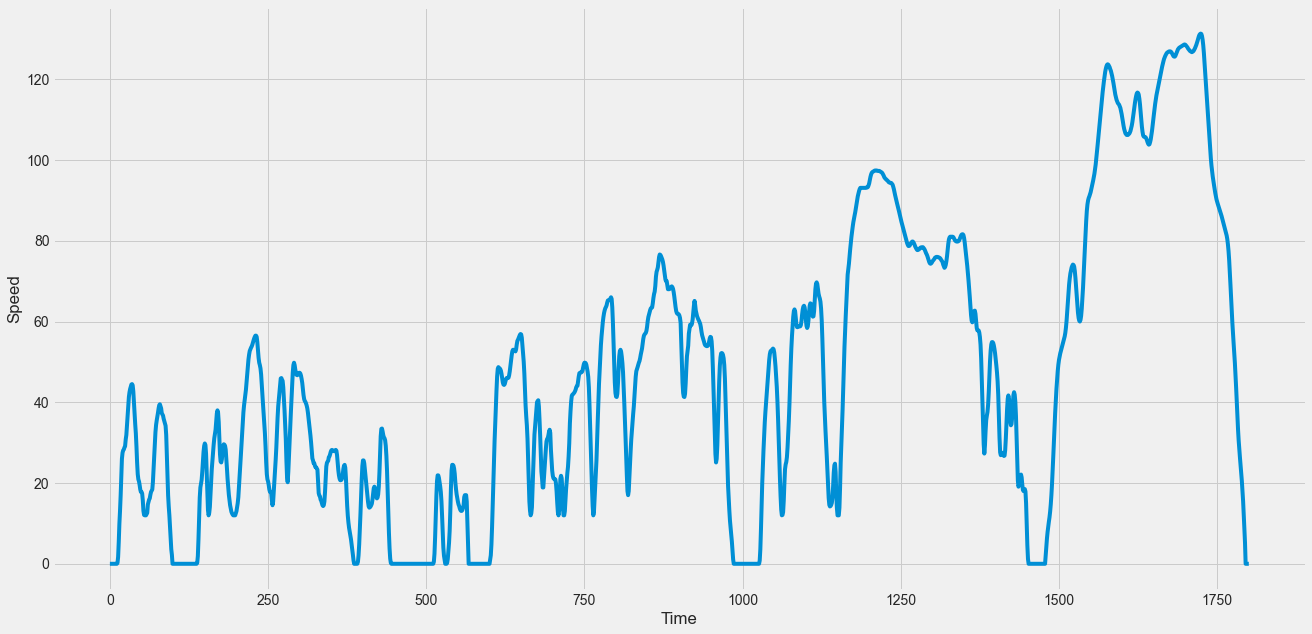

In [55]:
plt.figure (figsize = (20 , 10))

xi = 'Time'
yi = 'Speed'

plt.plot(df_op[xi] , df_op[yi])


plt.xlabel(xi)
plt.ylabel(yi)

plt.show()

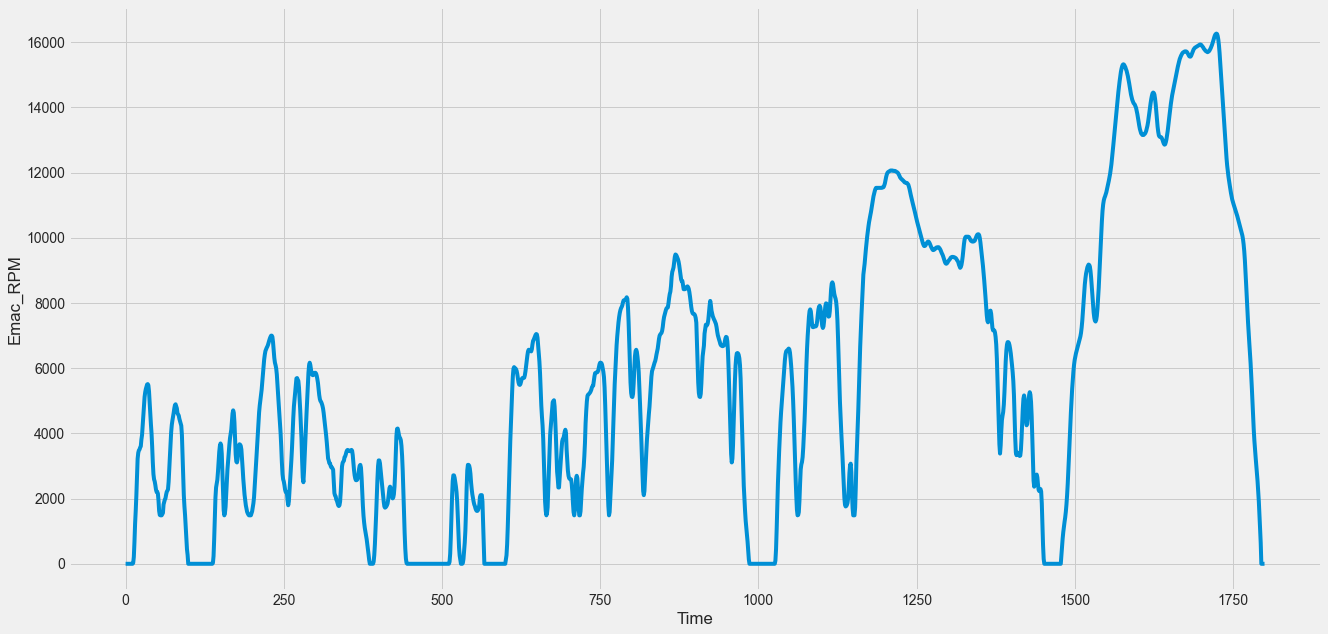

In [56]:
plt.figure (figsize = (20 , 10))

xi = 'Time'
yi = 'Emac_RPM'

plt.plot(df_op[xi] , df_op[yi])


plt.xlabel(xi)
plt.ylabel(yi)

plt.show()

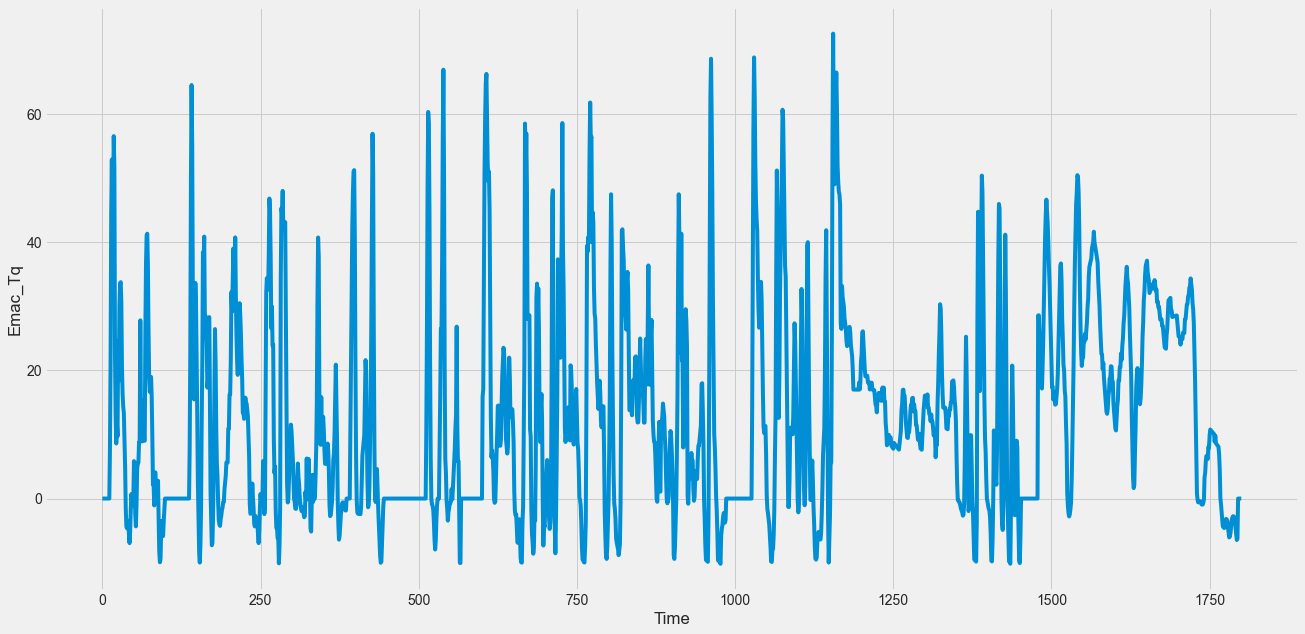

In [57]:
plt.figure (figsize = (20 , 10))

xi = 'Time'
yi = 'Emac_Tq'

plt.plot(df_op[xi] , df_op[yi])


plt.xlabel(xi)
plt.ylabel(yi)

plt.show()

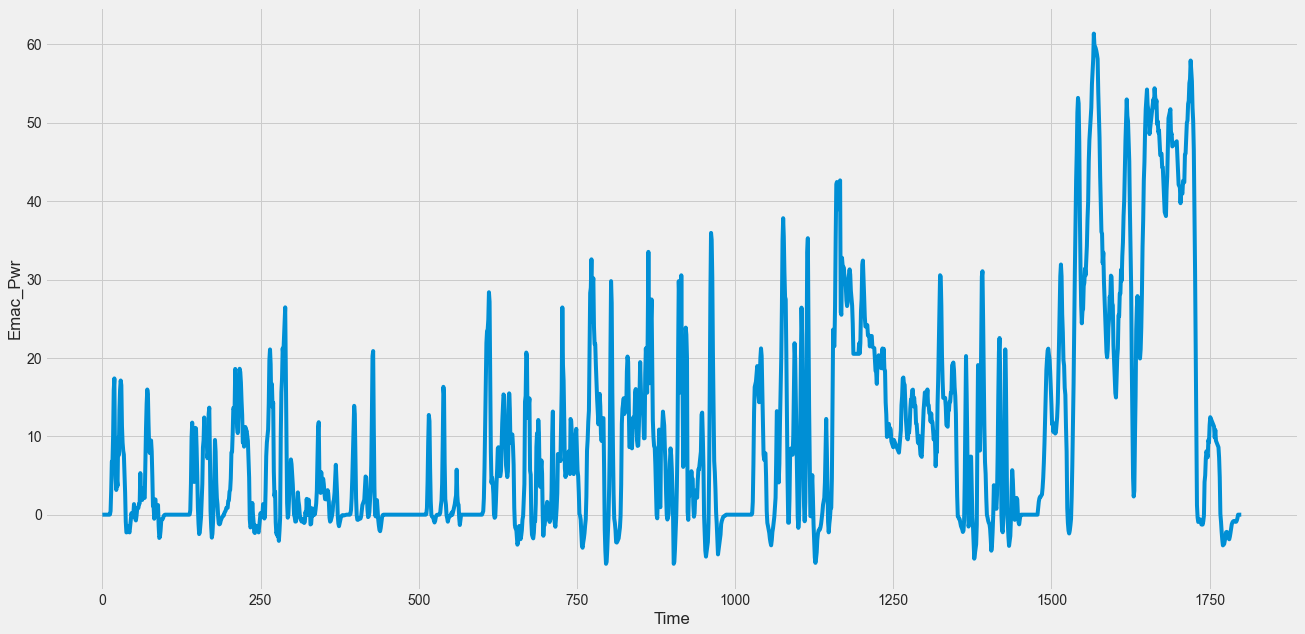

In [58]:
plt.figure (figsize = (20 , 10))

xi = 'Time'
yi = 'Emac_Pwr'

plt.plot(df_op[xi] , df_op[yi])


plt.xlabel(xi)
plt.ylabel(yi)

plt.show()

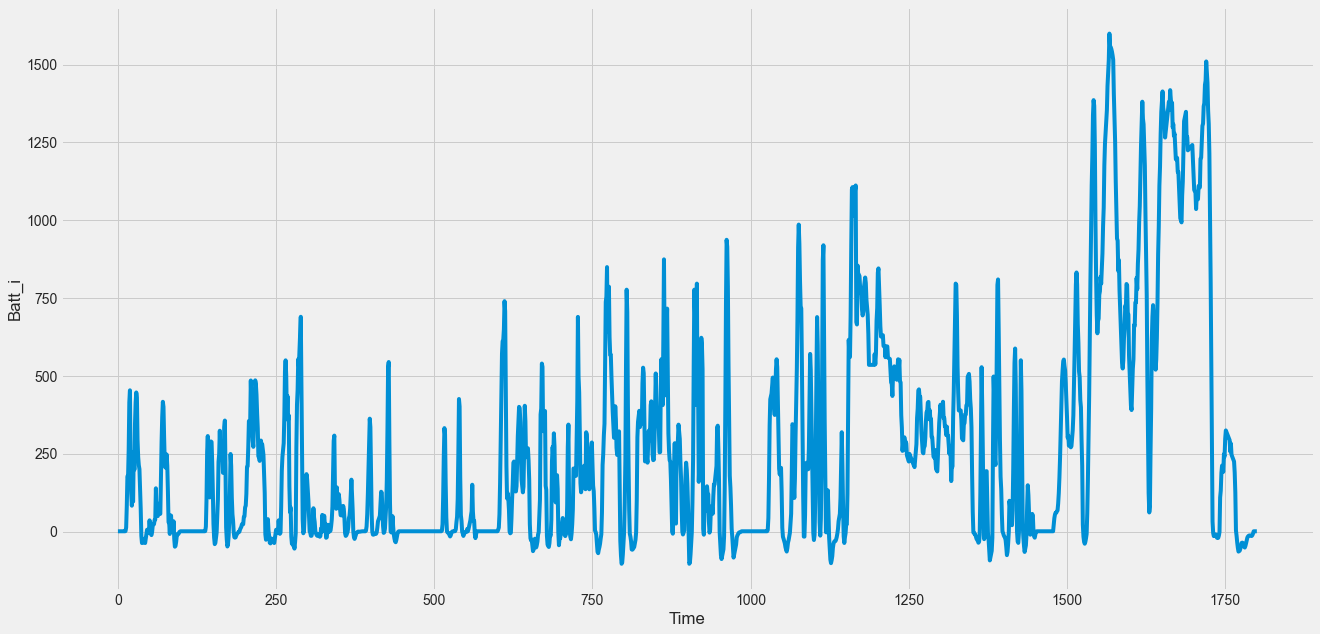

In [59]:
plt.figure (figsize = (20 , 10))

xi = 'Time'
yi = 'Batt_i'

plt.plot(df_op[xi] , df_op[yi])


plt.xlabel(xi)
plt.ylabel(yi)

plt.show()

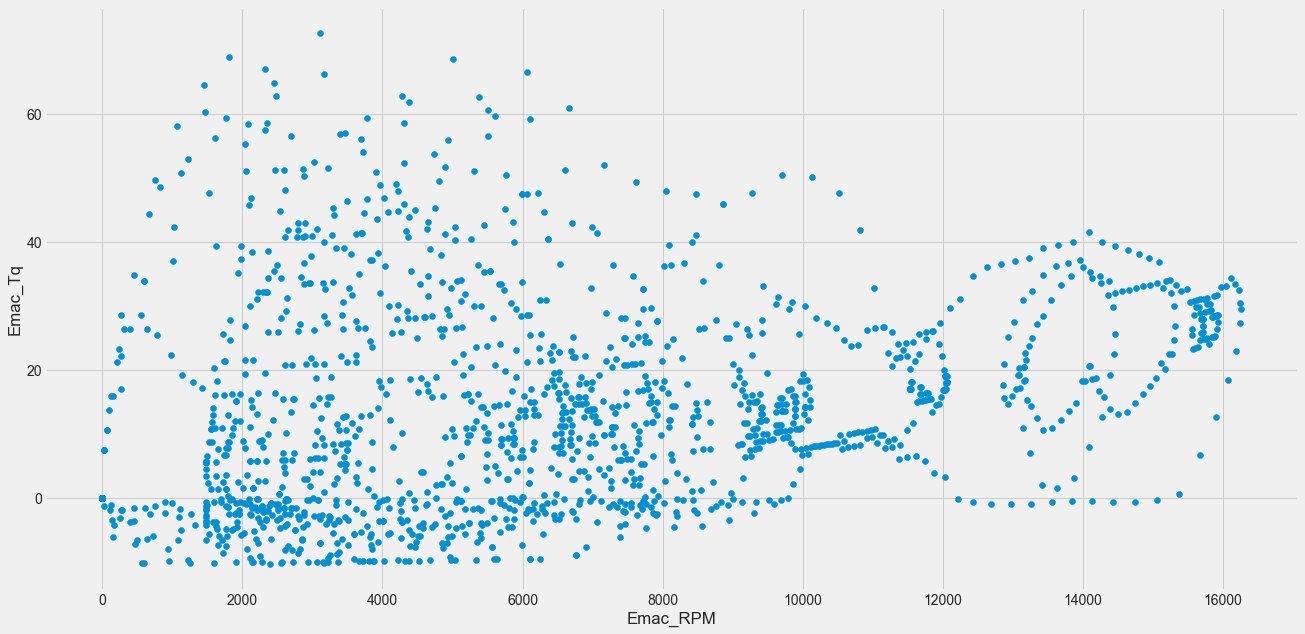

In [60]:
plt.figure (figsize = (20 , 10))

xi = 'Emac_RPM'
yi = 'Emac_Tq'

plt.scatter(df_op[xi] , df_op[yi])


plt.xlabel(xi)
plt.ylabel(yi)

plt.show()

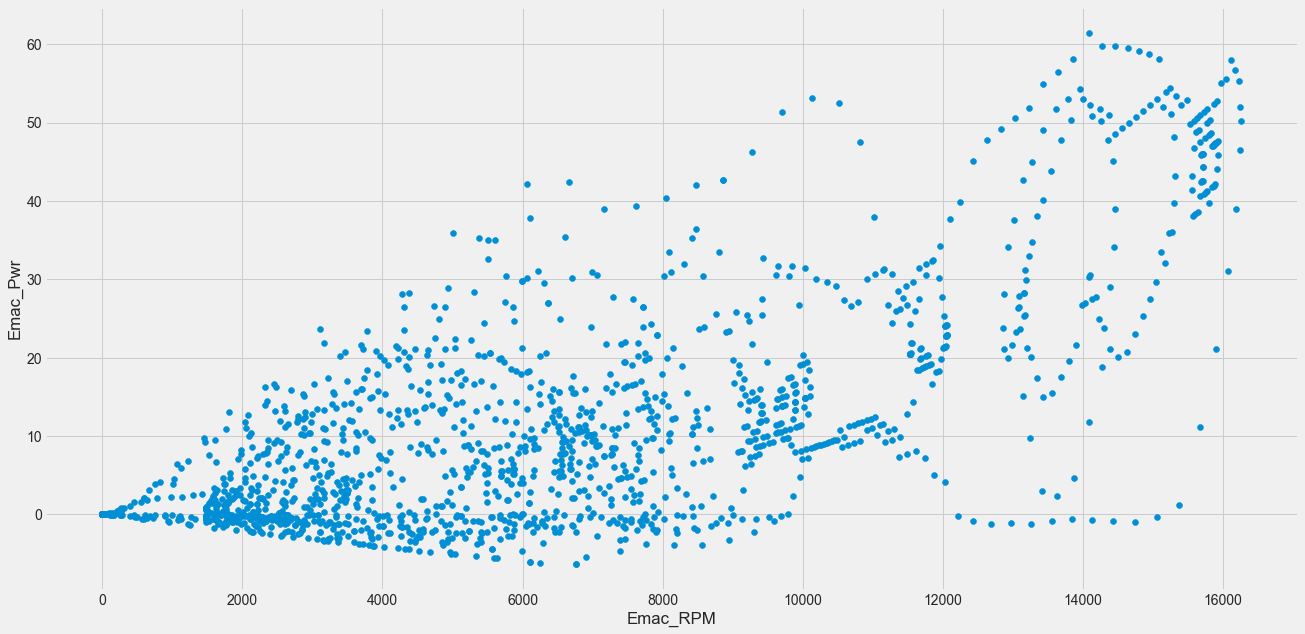

In [61]:
plt.figure (figsize = (20 , 10))

xi = 'Emac_RPM'
yi = 'Emac_Pwr'

plt.scatter(df_op[xi] , df_op[yi])


plt.xlabel(xi)
plt.ylabel(yi)

plt.show()

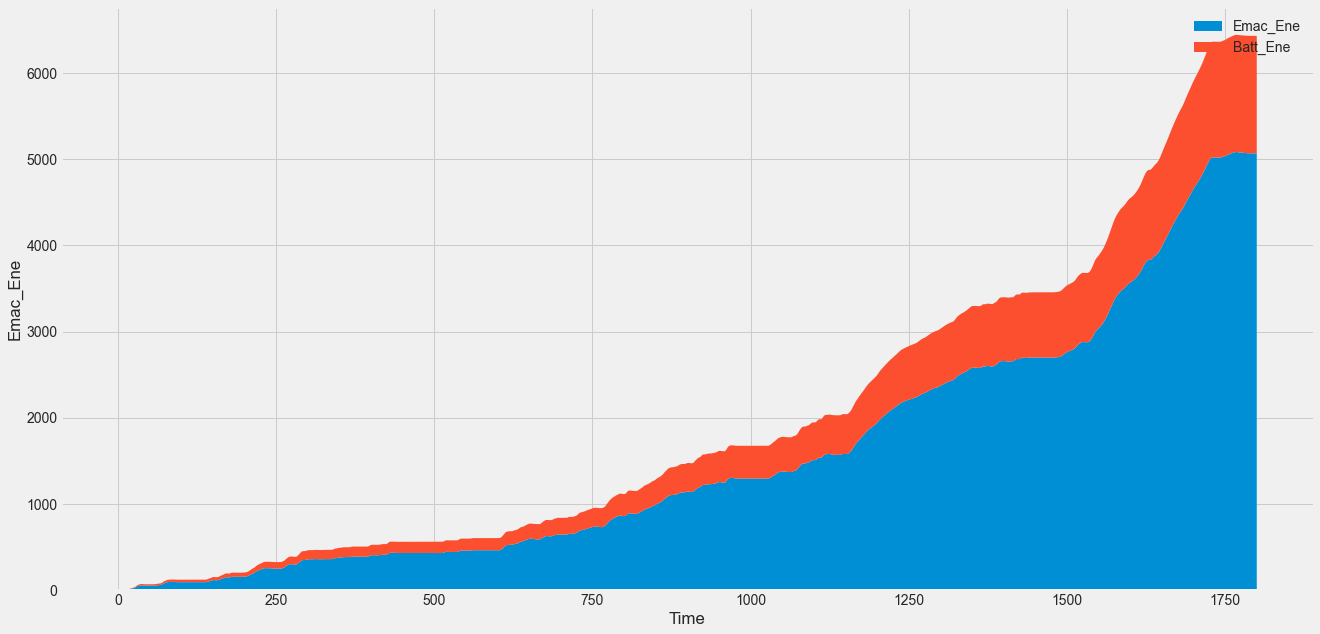

In [77]:
plt.figure (figsize = (20 , 10))

xi = 'Time'
y1 = 'Emac_Ene'
y2 = 'Batt_Ene'

# plt.fill_between(df_op[xi] , df_op[y1])
# plt.fill_between(df_op[xi] , df_op[y2] - df_op[y1])

plt.stackplot(df_op[xi]
             , df_op[y1]
             , df_op[y2] - df_op[y1]
              , labels = [y1 , y2]
             )

plt.xlabel(xi)
plt.ylabel(yi)

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


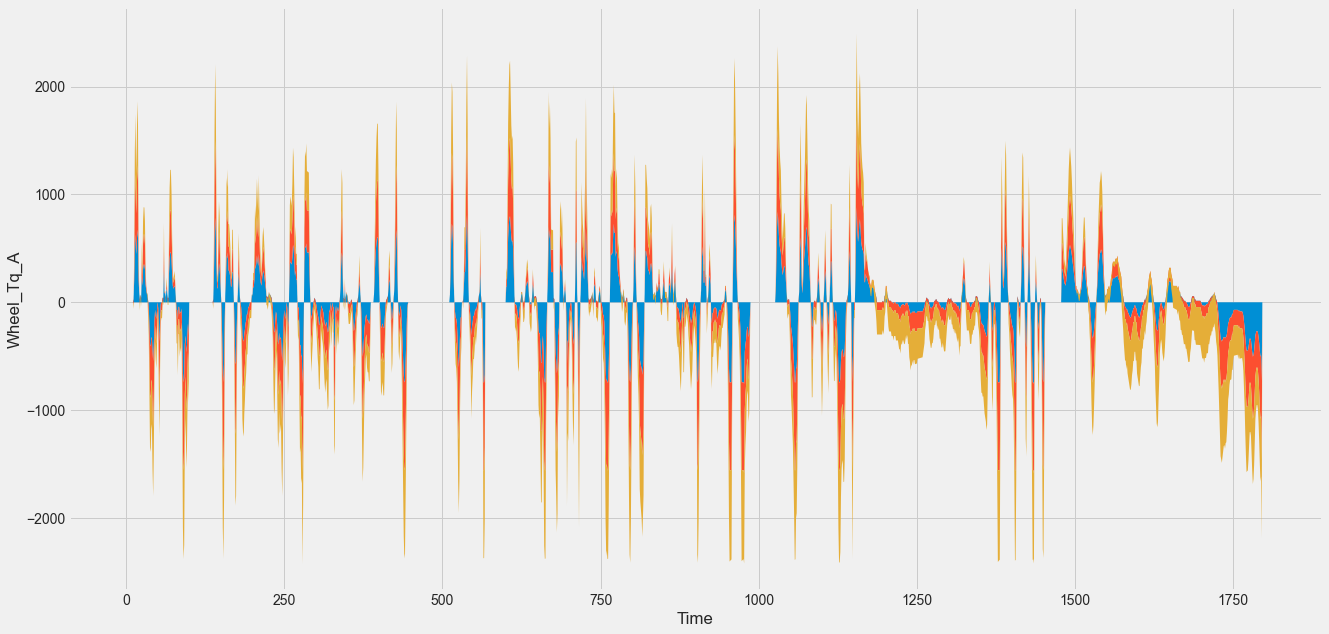

In [83]:
plt.figure (figsize = (20 , 10))

xi = 'Time'
y1 = 'Wheel_Tq_A'
y2 = 'Wheel_Tq_acc'
y3 = 'Wheel_Tq_B'
y4 = 'Wheel_Tq_C'

# plt.fill_between(df_op[xi] , df_op[y1])
# plt.fill_between(df_op[xi] , df_op[y2] - df_op[y1])

plt.stackplot(df_op[xi]
             , df_op[y2]
             , df_op[y2] - df_op[y1]
              , df_op[y2] - df_op[y1] - df_op[y4] 
#               , labels = [y1 , y2]
             )

plt.xlabel(xi)
plt.ylabel(y1)

plt.legend()
plt.show()